## Семинар 7: "Методы оптимизации"

ФИО:

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
%matplotlib inline

In [16]:
import torch
from tqdm.auto import tqdm
from torch import nn
from torchvision import datasets, transforms

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, RMSProp, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [1]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()
    
    def pre_step(self):
        pass
    
    def step(self):
        pass
    
    def update_param(self, p):
        raise NotImplementedError()


In [2]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths[0], weigths[1])
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points)
    losses = torch.FloatTensor(losses)
    return points, losses


In [3]:
def compare_optimizers(
    fn,
    optim_list,
    start_point,
    x_range=(-5, 5),
    y_range=(-5, 5),
    xstep=0.2,
    ystep=0.2,
    minima=None,
    num_iter = 50,
):
    xmin, xmax = x_range
    ymin, ymax = y_range
    x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
    z = fn(torch.from_numpy(x), torch.from_numpy(y))
    z = z.detach().numpy()
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
    if minima:
        ax.plot(*minima, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    
    colors = cm.rainbow(np.linspace(0, 1, len(optim_list)))
    
    for c, (name, optim, args) in zip(colors, optim_list):
        points, losses = optimize_function(fn, optim, args, start_point, num_iter)
        ax.quiver(
            points[:-1, 0], points[:-1, 1],  
            points[1:, 0] - points[:-1, 0], points[1:, 1] - points[:-1, 1], 
            scale_units='xy', angles='xy', scale=1, color=c,
            label=name
        )
    
    ax.legend()
    plt.show()
        
        

In [4]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-4):
        super().__init__(params)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad
        

In [5]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-4, gamma=0.9):
        super().__init__(params)
        self.params = params
        self.lr = lr
        self.v = [torch.zeros_like(param) for param in self.params]
        self.gamma = gamma
    
    def step(self):
        with torch.no_grad():
            for v, p in zip(self.v, self.params):
                if p.grad is None:
                    continue
                v = (self.gamma * v + self.lr * p.grad).clone().detach()
                p -= v

In [6]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-4, gamma=0.9):
        super().__init__(params)
        self.params = params
        self.lr = lr
        self.v = [torch.zeros_like(param) for param in self.params]
        self.gamma = gamma

    def pre_step(self):
        with torch.no_grad():
            for v, param in zip(self.v, self.params):
                param -= self.gamma * v

    def step(self):
        with torch.no_grad():
            for v, p in zip(self.v, self.params):
                if p.grad is None:
                    continue
                p += self.gamma * v
                v.copy_(self.gamma * v + self.lr * p.grad)
                p -= v

In [19]:
class RMSProp(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9, eps=1e-9):
        super().__init__(params)
        self.params = params
        self.lr = lr
        self.eps = eps
        self.G = [torch.zeros_like(param) for param in self.params]
        self.gamma = gamma

    def step(self):
        with torch.no_grad():
            for g, p in zip(self.G, self.params):
                if p.grad is None:
                    continue
                g = self.gamma * g + (1 - self.gamma) * p.grad ** 2
                p -= self.lr * p.grad / torch.sqrt(g + self.eps)

In [114]:
class AdaGrad(Optimizer):
    def __init__(self, params, lr=1, gamma=0.9, eps=1e-10):
        super().__init__(params)
        self.params = params
        self.lr = lr
        self.eps = eps
        self.G = [torch.zeros_like(param) for param in self.params]
        self.gamma = gamma

    def step(self):
        with torch.no_grad():
            for g, p in zip(self.G, self.params):
                if p.grad is None:
                    continue
                g += p.grad ** 2
                p -= self.lr * p.grad / torch.sqrt(g + self.eps)

In [77]:
class AdaDelta(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9, eps=1e-9):
        super().__init__(params)
        self.lr = lr
        self.eps = eps
        self.G = [torch.zeros_like(param) for param in self.params]
        self.D = [torch.zeros_like(param) for param in self.params]
        self.gamma = gamma

    def step(self):
        with torch.no_grad():
            for g, d, p in zip(self.G, self.D, self.params):
                if p.grad is None:
                    continue
                g = self.gamma * g + (1 - self.gamma) * p.grad ** 2
                delta = p.grad * torch.sqrt(d + self.eps) / torch.sqrt(g + self.eps)
                d = self.gamma * d + (1 - self.gamma) * delta ** 2
                p -= self.gamma * delta

In [22]:
class MyAdam(Optimizer):
    def __init__(self, params, lr=1e-4, gamma=0.9, eps=1e-10, alpha=0.9):
        super().__init__(params)
        self.params = params
        self.alpha = alpha
        self.lr = lr
        self.eps = eps
        self.V = [torch.zeros_like(param) for param in self.params]
        self.G = [torch.zeros_like(param) for param in self.params]
        self.gamma = gamma

    def step(self):
        with torch.no_grad():
            for v, g, p in zip(self.V, self.G, self.params):
                if p.grad is None:
                    continue
                v = self.gamma * v + (1 - self.gamma) * p.grad
                g = self.alpha * g + (1 - self.alpha) * p.grad ** 2
                p -= self.lr / (torch.sqrt(g) + self.eps) * v

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [23]:
def F1(x, y):
    return x**2 + y**2

def F2(x, y):
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

In [24]:
from torch.optim import Adagrad, Adam

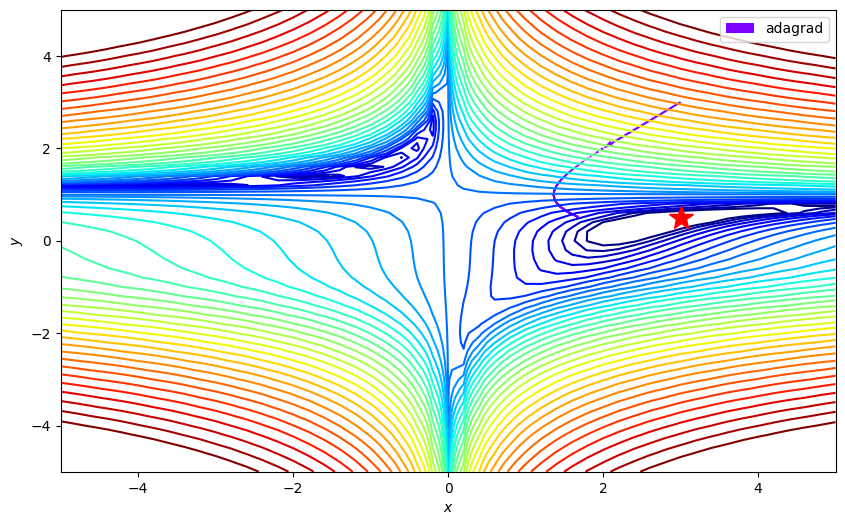

In [124]:
compare_optimizers(
    F2,
    [
        #('sgd', SGD, dict(lr=1e-4)),
        #('momentum', Momentum, dict(lr=1e-4)),
        #('nag', NAG, dict(lr=1e-4)),
        #('rmsprop', RMSProp, dict(lr=1e-2)),
        #('adagrad', AdaGrad, dict(lr=1, eps=1e-9, gamma=0.9)),
        #('adadelta', AdaDelta, dict(lr=1e-3, gamma=0.9, eps=1e-5)),
        #('myadam', MyAdam, dict(lr=1e-1, eps=1e-2, alpha=0.9, gamma=0.9))
    ],
    start_point=[3,3],
    minima=(3,0.5),
    num_iter=500
)

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [79]:
def F3(x, y):
    return x**2 * torch.sin(x) + y**2 * torch.sin(y)

/var/folders/4c/gl4vb4t52cb7gx03zf6ywqz40000gp/T/ipykernel_66782/2821451241.py:19: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)


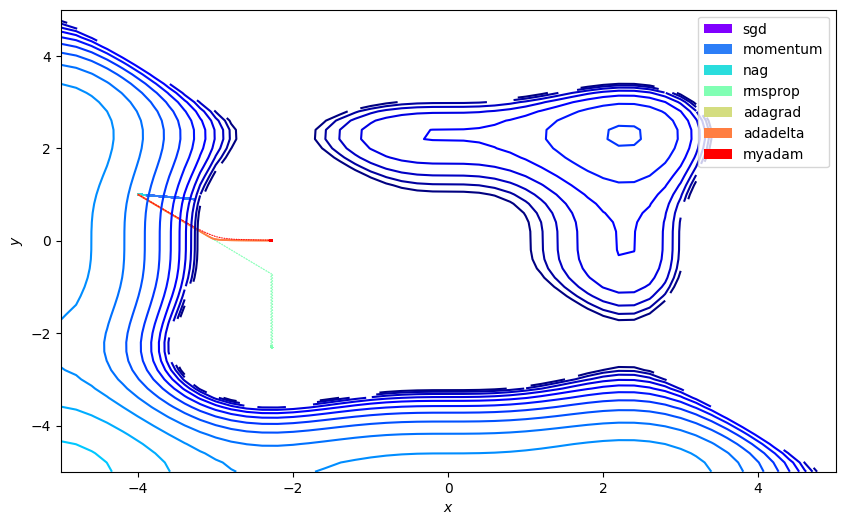

In [87]:
compare_optimizers(
    F3,
    [
        ('sgd', SGD, dict(lr=1e-4)),
        ('momentum', Momentum, dict(lr=1e-4)),
        ('nag', NAG, dict(lr=1e-6)),
        ('rmsprop', RMSProp, dict(lr=1e-2)),
        ('adagrad', AdaGrad, dict(lr=1e-2, eps=1e-9, gamma=0.9)),
        ('adadelta', AdaDelta, dict(lr=1e-3, gamma=0.9, eps=1e-5)),
        ('myadam', MyAdam, dict(lr=1e-1, eps=1e-2, alpha=0.9, gamma=0.9))
    ],
    start_point=[-4, 1],
    num_iter=500
)

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [89]:
def F4(x, y):
    return x**2 * torch.sin(x**2) + y**2 * torch.sin(y**2)

/var/folders/4c/gl4vb4t52cb7gx03zf6ywqz40000gp/T/ipykernel_66782/2821451241.py:19: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)


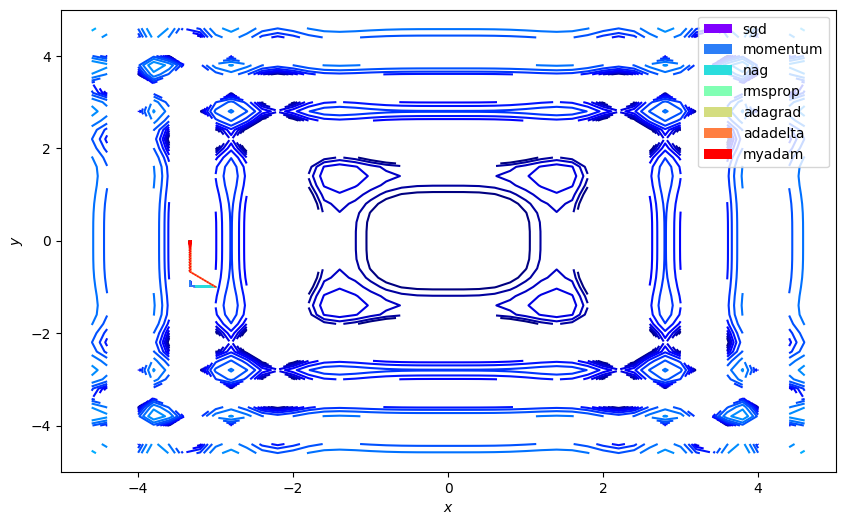

In [96]:
compare_optimizers(
    F4,
    [
        ('sgd', SGD, dict(lr=1e-4)),
        ('momentum', Momentum, dict(lr=1e-4)),
        ('nag', NAG, dict(lr=1e-6)),
        ('rmsprop', RMSProp, dict(lr=1e-2)),
        ('adagrad', AdaGrad, dict(lr=1e-2, eps=1e-9, gamma=0.9)),
        ('adadelta', AdaDelta, dict(lr=1e-3, gamma=0.9, eps=1e-5)),
        ('myadam', MyAdam, dict(lr=1e-1, eps=1e-2, alpha=0.9, gamma=0.9))
    ],
    start_point=[-3, -1],
    num_iter=500
)

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i>

In [97]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2022-11-14 04:52:25--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2022-11-14 04:52:25--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.2’

MNIST.tar.gz.2          [           <=>      ]  33.20M  14.5MB/s    in 2.3s    

2022-11-14 04:52:27 (14.5 MB/s) - ‘MNIST.tar.gz.2’ saved [34813078]

x MNIST/
x MNIST/raw/
x MNIST/raw/train-labels-idx1-ubyte
x MNIST/raw/t10k-labels-idx1-ubyte.gz
x MNIST/raw/t10k-labels-idx1-ubyte
x MNIST/raw/t10k-images-idx3-ubyte.gz
x MNIST/raw/train-images-idx3-ubyte
x MNIST/raw/train-labels-idx1-ubyte.gz
x MNIST/raw/t10k-images-id

In [98]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [99]:
image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1),
                                         nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, 3, padding=1),
                                         nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(3136, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [100]:
from IPython.core.display_functions import clear_output


def train(network, epochs, learning_rate, myOptimizer):
    loss = nn.NLLLoss()
    optimizer = myOptimizer(network.parameters(), lr = learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
            test_loss_epochs, \
            train_accuracy_epochs, \
            test_accuracy_epochs

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

Epoch 4... (Train/Test) NLL: 0.536/0.470	Accuracy: 0.856/0.872


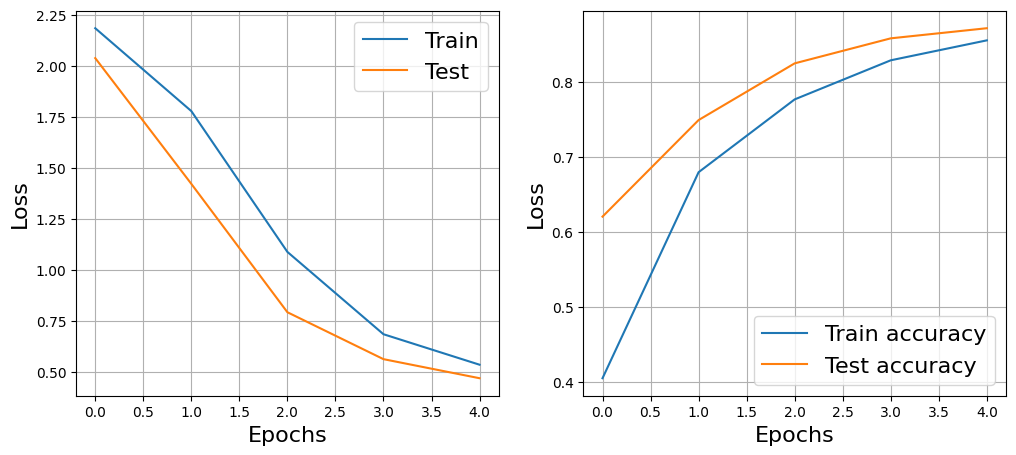

([2.183852877998352,
  1.7779848865509034,
  1.0882840922355652,
  0.6851288187980652,
  0.5357858142137527],
 [2.037411789924573,
  1.4215876858074443,
  0.7928244682927482,
  0.563008460707177,
  0.4696151640373297],
 [0.40525, 0.6798, 0.77685, 0.82895, 0.8555333333333334],
 [0.6206070287539937,
  0.7493011182108626,
  0.8248801916932907,
  0.8582268370607029,
  0.8717052715654952])

In [101]:
network = ConvClassifier(image_size=28)
train(network, 5, 1e-4, SGD)

Epoch 4... (Train/Test) NLL: 2.308/2.307	Accuracy: 0.141/0.148


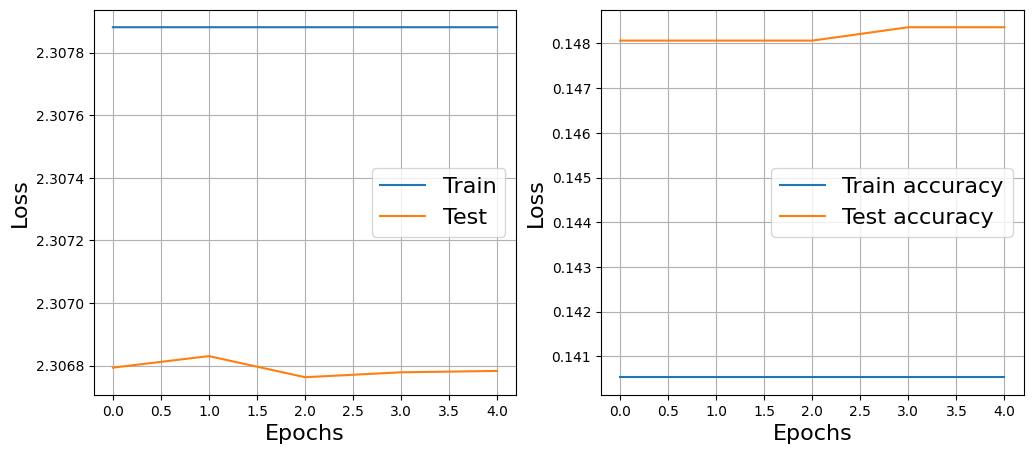

([2.3078812029520672,
  2.3078811962127688,
  2.3078812037150067,
  2.3078811979929608,
  2.3078812044779458],
 [2.306793768946736,
  2.306830555486222,
  2.3067631233995334,
  2.3067788209397193,
  2.3067832160681583],
 [0.14053333333333334,
  0.14053333333333334,
  0.14053333333333334,
  0.14053333333333334,
  0.14053333333333334],
 [0.14806309904153356,
  0.14806309904153356,
  0.14806309904153356,
  0.1483626198083067,
  0.1483626198083067])

In [102]:
network = ConvClassifier(image_size=28)
train(network, 5, 1e-6, NAG)

Epoch 4... (Train/Test) NLL: 2.312/2.311	Accuracy: 0.072/0.069


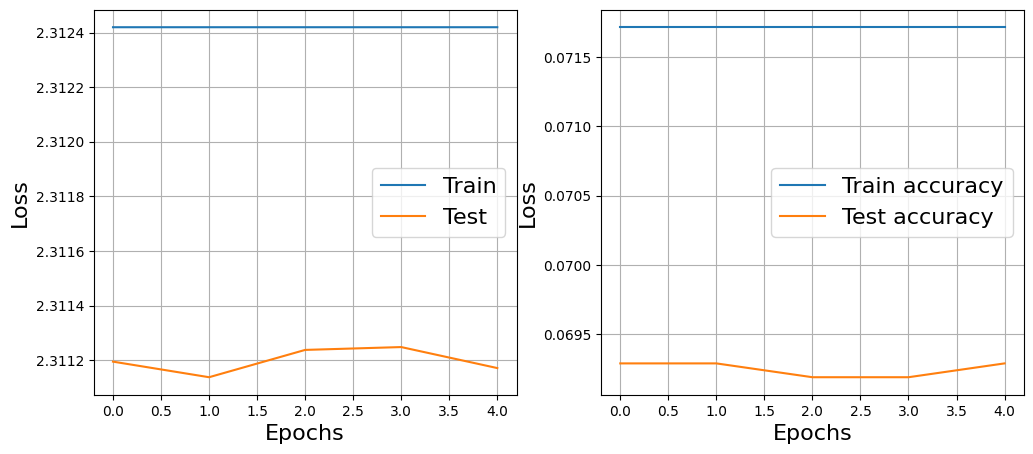

([2.312419394683838,
  2.312419390741984,
  2.312419386927287,
  2.3124193954467773,
  2.3124193992614748],
 [2.311194371872436,
  2.3111372702418804,
  2.3112373192089435,
  2.311247743356723,
  2.3111707836675186],
 [0.07171666666666666,
  0.07171666666666666,
  0.07171666666666666,
  0.07171666666666666,
  0.07171666666666666],
 [0.0692891373801917,
  0.0692891373801917,
  0.06918929712460063,
  0.06918929712460063,
  0.0692891373801917])

In [110]:
network = ConvClassifier(image_size=28)
train(network, 5, 1e-4, Momentum)

Epoch 4... (Train/Test) NLL: 2.321/2.321	Accuracy: 0.091/0.096


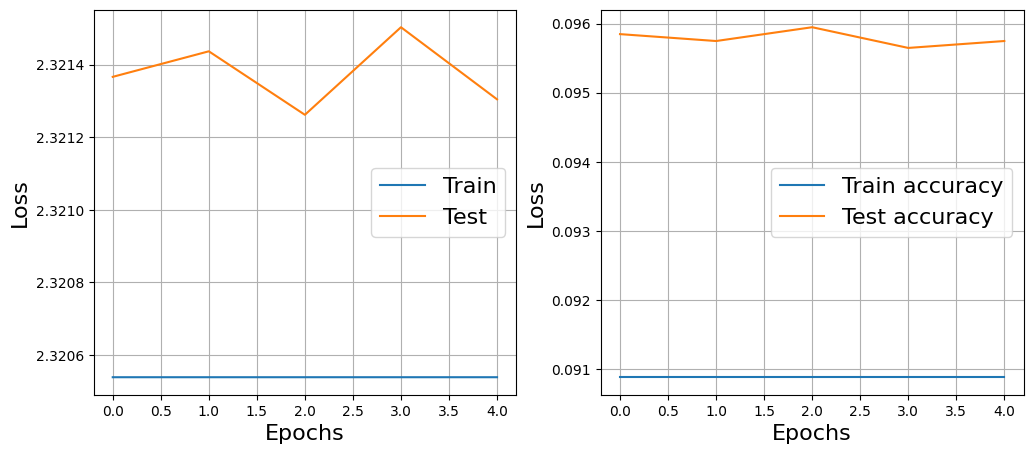

([2.320538922627767,
  2.320538924916585,
  2.320538917541504,
  2.3205389275868735,
  2.320538927968343],
 [2.3213664609403275,
  2.32143684621817,
  2.3212619102039276,
  2.3215031852356542,
  2.3213045376177415],
 [0.09088333333333333,
  0.09088333333333333,
  0.09088333333333333,
  0.09088333333333333,
  0.09088333333333333],
 [0.09584664536741214,
  0.09574680511182108,
  0.09594648562300319,
  0.09564696485623003,
  0.09574680511182108])

In [125]:
network = ConvClassifier(image_size=28)
train(network, 5, 1, AdaGrad)

Epoch 4... (Train/Test) NLL: 0.167/0.138	Accuracy: 0.950/0.959


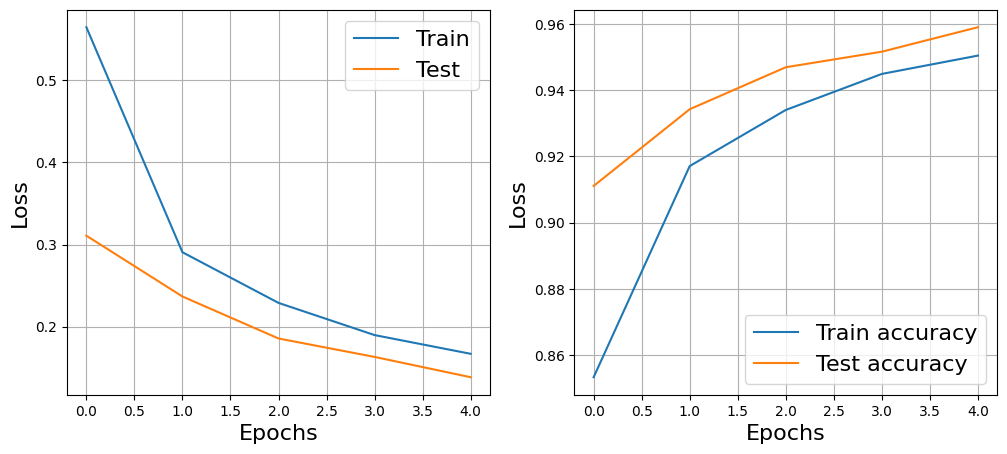

([0.5647343394358952,
  0.2906960798194011,
  0.22900952954267462,
  0.18980831747998794,
  0.1670156207504372],
 [0.31087958166441215,
  0.23680342405367963,
  0.18566233754907838,
  0.16322531320226077,
  0.13849362585925684],
 [0.8533, 0.91705, 0.9339833333333334, 0.9448666666666666, 0.9504],
 [0.9110423322683706,
  0.9342052715654952,
  0.9468849840255591,
  0.9515774760383386,
  0.9589656549520766])

In [112]:
network = ConvClassifier(image_size=28)
train(network, 5, 1e-3, AdaDelta)

Epoch 4... (Train/Test) NLL: 2.314/2.316	Accuracy: 0.094/0.087


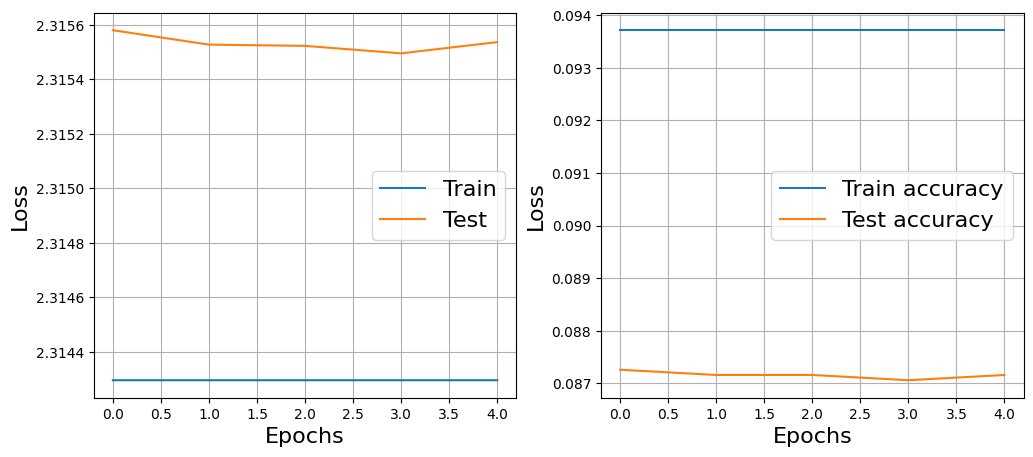

([2.3142964813232423,
  2.314296478398641,
  2.3142964771270753,
  2.3142964764912923,
  2.3142964791615803],
 [2.3155804556398727,
  2.3155275891764093,
  2.3155230119967234,
  2.3154956045242163,
  2.315536767149124],
 [0.09371666666666667,
  0.09371666666666667,
  0.09371666666666667,
  0.09371666666666667,
  0.09371666666666667],
 [0.08726038338658147,
  0.08716054313099042,
  0.08716054313099042,
  0.08706070287539937,
  0.08716054313099042])

In [127]:
network = ConvClassifier(image_size=28)
train(network, 5, 2, MyAdam)

#### Feedback (опционально)

##### Пояснение к работе:
Пытался что-то сделать, изменить, чтобы повлиять на accuracy, но спустя 2.5 недели просиживания на данной работе, я так и не понял что с моими оптимизаторами не так :(((
Вроде бы беру все по формулам из общедоступных источников. Вроде бы на несложных функциях все относительно хорошо сходится. А вот на датасете всё очень плохо. Очень.

Отправлю то, что есть :((((((((((((((((((((((((((((((((((((

UPD: переписав с использованием обычных питоновских операторов, НС начала хорошо сходиться при adaDelta. С другими же такая же беда, как и была. Странно(

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: